In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker



# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [2]:
session = fastf1.get_session(2023,12,5)
session.load()
fastf1.Cache.enable_cache('cache') 

api         WARNING 	

NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

core           INFO 	Loading data for Belgian Grand Prix - Race [v2.3.1]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:

### Pre defined

In [3]:
compound_color = {'HARD': 'F0F0EC', 
                  'INTERMEDIATE': '43B02A', 
                  'MEDIUM': 'FFD12E', 
                  'SOFT': 'DA291C', 
                  'TEST-UNKNOWN': '434649', 
                  'UNKNOWN': '00FFFF', 
                  'WET': '0067AD'}
compound = ['All Compounds','SOFT','MEDIUM','HARD']

In [4]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

In [5]:
# Recuperer le max des tours 
def max_lap(laps):
    grouped = laps.groupby("Driver") # regroup drivers 
    count_values = grouped['LapNumber'].count() #calculate lap number of each driver
    return count_values.max() # return the maximum of laps

In [6]:
laps = session.laps # getting laps of session
drivers = session.drivers[:20] # getting all drivers participate on race 
all_laps = laps
all_laps['LapStartTimeS'] = all_laps["LapStartTime"].dt.total_seconds() # add lap start time in seconds to calculate gap 
all_laps['DeltaTime'] = 0 # add column Delta time filled with 0

In [7]:
# winner = session.results.loc[session.results["Position"]==1,"DriverNumber"].values
winner = '1'

In [8]:
#making a new variable called delta_time which contain all laps with limited columns 
delta_time = all_laps[["DriverNumber","Driver","LapNumber","LapStartTime","LapStartTimeS","DeltaTime"]] 
# loop to calculate race gap to race winner
for i in drivers:
    #calculate the difference between race winner and other drivers on the laps Start Time Seconds 
    a = delta_time.loc[delta_time["DriverNumber"] == i,["LapStartTimeS"]].reset_index() - delta_time.loc[delta_time["DriverNumber"] == '1',["LapStartTimeS"]].reset_index()
    #calculate number of laps drived by each driver to comparite with race winner
    length = len(delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"])
    #affect a list of gap values to the driver on the column DeltaTime which was 0 
    delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"] = a.loc[:, "LapStartTimeS"].values[:length] # list of gap for all laps 

### Race Results 

In [9]:
# race Results 
results_race = session.results[["DriverNumber","BroadcastName","Points","Position","GridPosition"]]
# add column PositionGainded by calculating the difference between Grid position and final position of race
results_race["PositionGained"] = results_race["GridPosition"] - results_race["Position"]
results_race[["DriverNumber","BroadcastName","Points","Position","PositionGained"]]


C:\Users\GTR\AppData\Local\Temp\ipykernel_4452\3998062495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_race["PositionGained"] = results_race["GridPosition"] - results_race["Position"]


,DriverNumber,BroadcastName,Points,Position,PositionGained
1,1,M VERSTAPPEN,25.0,1.0,5.0
11,11,S PEREZ,18.0,2.0,0.0
16,16,C LECLERC,15.0,3.0,-2.0
44,44,L HAMILTON,13.0,4.0,-1.0
14,14,F ALONSO,10.0,5.0,4.0
63,63,G RUSSELL,8.0,6.0,2.0
4,4,L NORRIS,6.0,7.0,0.0
31,31,E OCON,4.0,8.0,6.0
18,18,L STROLL,2.0,9.0,1.0
22,22,Y TSUNODA,1.0,10.0,1.0


### Gap to race winner graph

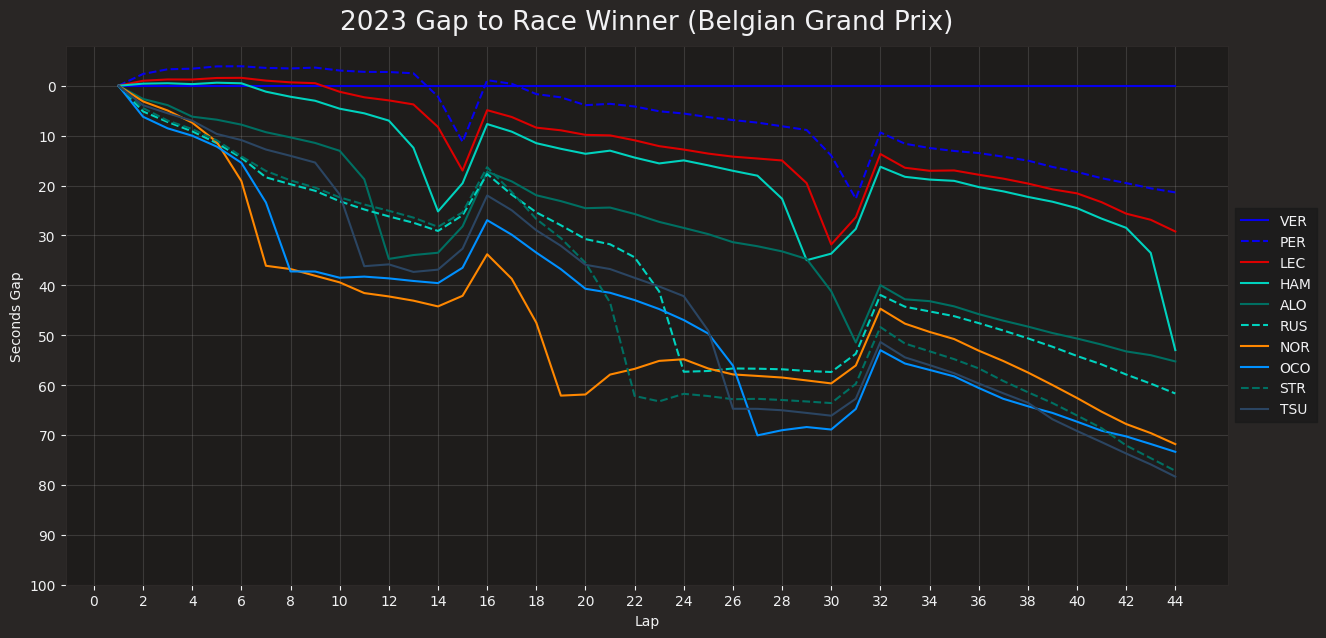

In [10]:
plt.figure(figsize=(15, 7))
color_picked = []
max_gap = int(delta_time["DeltaTime"].max())

# Adding the yellow zone from Lap 32 to Lap 38
# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)

# for i in drivers[:10]:
for i in drivers[:10]:
    x = delta_time.loc[delta_time["DriverNumber"]==i,["LapNumber"]]
    y = delta_time.loc[delta_time["DriverNumber"]==i,["DeltaTime"]]
    
    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    
    if team_color in color_picked:
        plt.plot(x, y, color=team_color, linestyle='dashed', label=driver_name)
    else:    
        plt.plot(x, y, color=team_color, linestyle='solid', label=driver_name)
        color_picked.append(team_color)

# Customize the plot
plt.title('2023 Gap to Race Winner ('+session.event["EventName"]+')')
plt.xlabel('Lap')
plt.ylabel('Seconds Gap')
labels = []
# for i in range(max_lap(laps)+1):
#     if (i % 10 != 0):
#         labels.append()
#     else:
#         labels.append(i)

plt.xticks(range(0, max_lap(laps)+1, 2))

plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()


# Hide tick labels for minor ticks

# Add grid
plt.grid(True, alpha=0.2)



# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.savefig('Graphes/Race/GapRaceWinner.png', dpi=300)
plt.show()



### Tires Strategy

In [11]:
#getting all drivers participated in the race 
drivers = session.drivers
#getting drivers abreviation 
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

We need to find the stint length and compound used
for every stint by every driver.
We do this by first grouping the laps by the driver,
the stint number, and the compound.
And then counting the number of laps in each group.



In [12]:
# getting all laps with 4 columns only to variable stints 
stints = session.laps[["Driver", "Stint", "Compound", "LapNumber"]]
# grouping by Driver Stint Compound to calculate the number of laps of each stint
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
# stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.rename(columns={"LapNumber": "StintLength"})

The number in the LapNumber column now stands for the number of observations
in that group aka the stint length.



Now we can plot the strategies for each driver



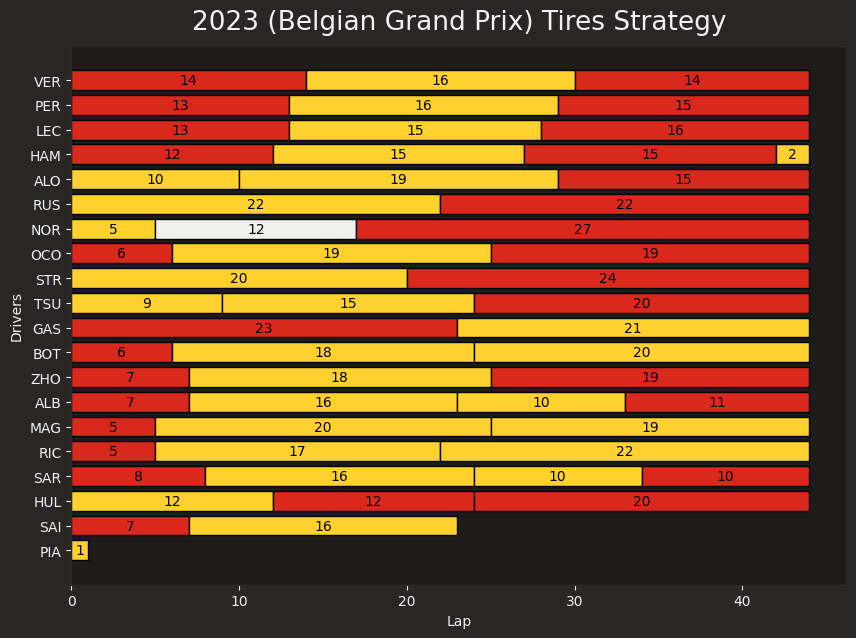

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

for driver in drivers_abr:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color='#'+compound_color[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        # Add the value over the bar
        plt.text(
            x=previous_stint_end + row["StintLength"] / 2,
            y=driver,
            s=str(row["StintLength"]),
            ha='center',
            va='center',
            color='black'  # Set text color to black
        )

        previous_stint_end += row["StintLength"]

# Customize the plot
plt.title('2023 (' + session.event["EventName"] + ') Tires Strategy')
plt.xlabel('Lap')
plt.ylabel('Drivers')
# plt.xticks(range(0, max_lap(laps), 5))
# plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()

# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)

plt.savefig('Graphes/Race/Tires_Strategy.png', dpi=300)
plt.show()



### Positions during the race

In [14]:
drivers = session.drivers

In [15]:
# getting race results 
first_lap = session.results
# changing grid position from 0 to 20
first_lap.loc[first_lap["GridPosition"] == 0,["GridPosition"]] = 20


In [16]:
# sorting results by grid position to represete start positions
first_lap = session.results[["DriverNumber","GridPosition"]].sort_values(by='GridPosition')
# adding column position that reprsente race start positions
first_lap["Position"] = list(range(1, 21))

In [17]:
laps.sort_values(by='LapNumber')

,Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Stint,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate,LapStartTimeS,DeltaTime
815,0 days 01:04:38.140000,81,NaT,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,False,MEDIUM,1.0,True,1,0 days 01:02:44.614000,McLaren,PIA,1,False,2023-07-30 13:03:45.833,3764.614,0
132,0 days 01:04:40.085000,44,NaT,1.0,0 days 00:16:52.457000,NaT,NaT,0 days 00:00:50.262000,0 days 00:00:29.960000,NaT,0 days 01:04:10.160000,0 days 01:04:40.144000,321.0,191.0,213.0,307.0,False,SOFT,1.0,True,1,0 days 01:02:44.614000,Mercedes,HAM,1,False,2023-07-30 13:03:45.833,3764.614,0
176,0 days 01:04:43.154000,14,NaT,1.0,0 days 00:14:23.600000,NaT,NaT,0 days 00:00:51.170000,0 days 00:00:30.448000,NaT,0 days 01:04:12.769000,0 days 01:04:43.254000,318.0,192.0,213.0,300.0,False,MEDIUM,1.0,True,1,0 days 01:02:44.614000,Aston Martin,ALO,1,False,2023-07-30 13:03:45.833,3764.614,0
220,0 days 01:04:45.659000,63,NaT,1.0,0 days 00:15:16.505000,NaT,NaT,0 days 00:00:52.141000,0 days 00:00:30.584000,NaT,0 days 01:04:15.145000,0 days 01:04:45.707000,315.0,191.0,213.0,280.0,False,MEDIUM,1.0,True,1,0 days 01:02:44.614000,Mercedes,RUS,1,False,2023-07-30 13:03:45.833,3764.614,0
264,0 days 01:04:43.647000,4,NaT,1.0,0 days 00:15:56.286000,NaT,NaT,0 days 00:00:51.511000,0 days 00:00:30.585000,NaT,0 days 01:04:13.238000,0 days 01:04:43.816000,320.0,191.0,211.0,294.0,False,MEDIUM,1.0,True,1,0 days 01:02:44.614000,McLaren,NOR,1,False,2023-07-30 13:03:45.833,3764.614,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0 days 02:26:28.984000,4,0 days 00:01:52.445000,44.0,NaT,NaT,0 days 00:00:32.957000,0 days 00:00:48.875000,0 days 00:00:30.613000,0 days 02:25:09.496000,0 days 02:25:58.371000,0 days 02:26:28.984000,309.0,185.0,203.0,303.0,False,SOFT,27.0,True,3,0 days 02:24:36.539000,McLaren,NOR,1,True,2023-07-30 14:25:37.758,8676.539,0
483,0 days 02:26:38.381000,10,0 days 00:01:53.093000,44.0,NaT,NaT,0 days 00:00:32.489000,0 days 00:00:50.151000,0 days 00:00:30.453000,0 days 02:25:17.777000,0 days 02:26:07.928000,0 days 02:26:38.381000,312.0,188.0,202.0,NaN,False,MEDIUM,21.0,True,2,0 days 02:24:45.288000,Alpine,GAS,1,True,2023-07-30 14:25:46.507,8685.288,0
87,0 days 02:25:37.600000,11,0 days 00:01:51.508000,44.0,NaT,NaT,0 days 00:00:32.535000,0 days 00:00:48.866000,0 days 00:00:30.107000,0 days 02:24:18.627000,0 days 02:25:07.493000,0 days 02:25:37.600000,307.0,193.0,216.0,295.0,False,SOFT,15.0,True,3,0 days 02:23:46.092000,Red Bull Racing,PER,1,True,2023-07-30 14:24:47.311,8626.092,0
571,0 days 02:26:50.724000,24,0 days 00:01:52.006000,44.0,NaT,NaT,0 days 00:00:32.266000,0 days 00:00:49.680000,0 days 00:00:30.060000,0 days 02:25:30.984000,0 days 02:26:20.664000,0 days 02:26:50.724000,320.0,191.0,214.0,313.0,False,SOFT,19.0,True,3,0 days 02:24:58.718000,Alfa Romeo,ZHO,1,True,2023-07-30 14:25:59.937,8698.718,0


In [18]:

position_drivers = pd.merge( laps.loc[(laps["LapNumber"] == 2)|(laps["LapNumber"] == 0),["DriverNumber","Driver","LapNumber","LapStartTime"]].reset_index(drop = True),first_lap[["DriverNumber","Position"]], on='DriverNumber', how='inner').sort_values(by = 'Position')

In [19]:
position_drivers["LapNumber"] = 1

In [20]:
position_drivers

,DriverNumber,Driver,LapNumber,LapStartTime,Position
2,16,LEC,1,0 days 01:04:39.507000,1.0
1,11,PER,1,0 days 01:04:38.140000,2.0
3,44,HAM,1,0 days 01:04:40.085000,3.0
18,55,SAI,1,0 days 01:04:42.788000,4.0
19,81,PIA,1,0 days 01:02:44.614000,5.0
0,1,VER,1,0 days 01:04:40.504000,6.0
6,4,NOR,1,0 days 01:04:43.647000,7.0
5,63,RUS,1,0 days 01:04:45.659000,8.0
4,14,ALO,1,0 days 01:04:43.154000,9.0
8,18,STR,1,0 days 01:04:44.976000,10.0


In [21]:
position_drivers_add = laps.loc[laps["LapNumber"] == 2,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
position_drivers_add["Position"] = list(range(1, 20))
position_drivers = pd.concat([position_drivers, position_drivers_add], ignore_index=True)
for i in range(3,max_lap(laps)+1):
    position_drivers_add = laps.loc[laps["LapNumber"] == i,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
    position_drivers_add["Position"] = list(range(1, len(position_drivers_add)+1))
    position_drivers = pd.concat([position_drivers, position_drivers_add], ignore_index=True)

In [22]:
drivers_abr = position_drivers.loc[position_drivers["LapNumber"]== 1,"Driver"].values

In [23]:
drivers_abr

array(['LEC', 'PER', 'HAM', 'SAI', 'PIA', 'VER', 'NOR', 'RUS', 'ALO',
       'STR', 'TSU', 'GAS', 'BOT', 'OCO', 'ALB', 'MAG', 'ZHO', 'SAR',
       'RIC', 'HUL'], dtype=object)

In [24]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

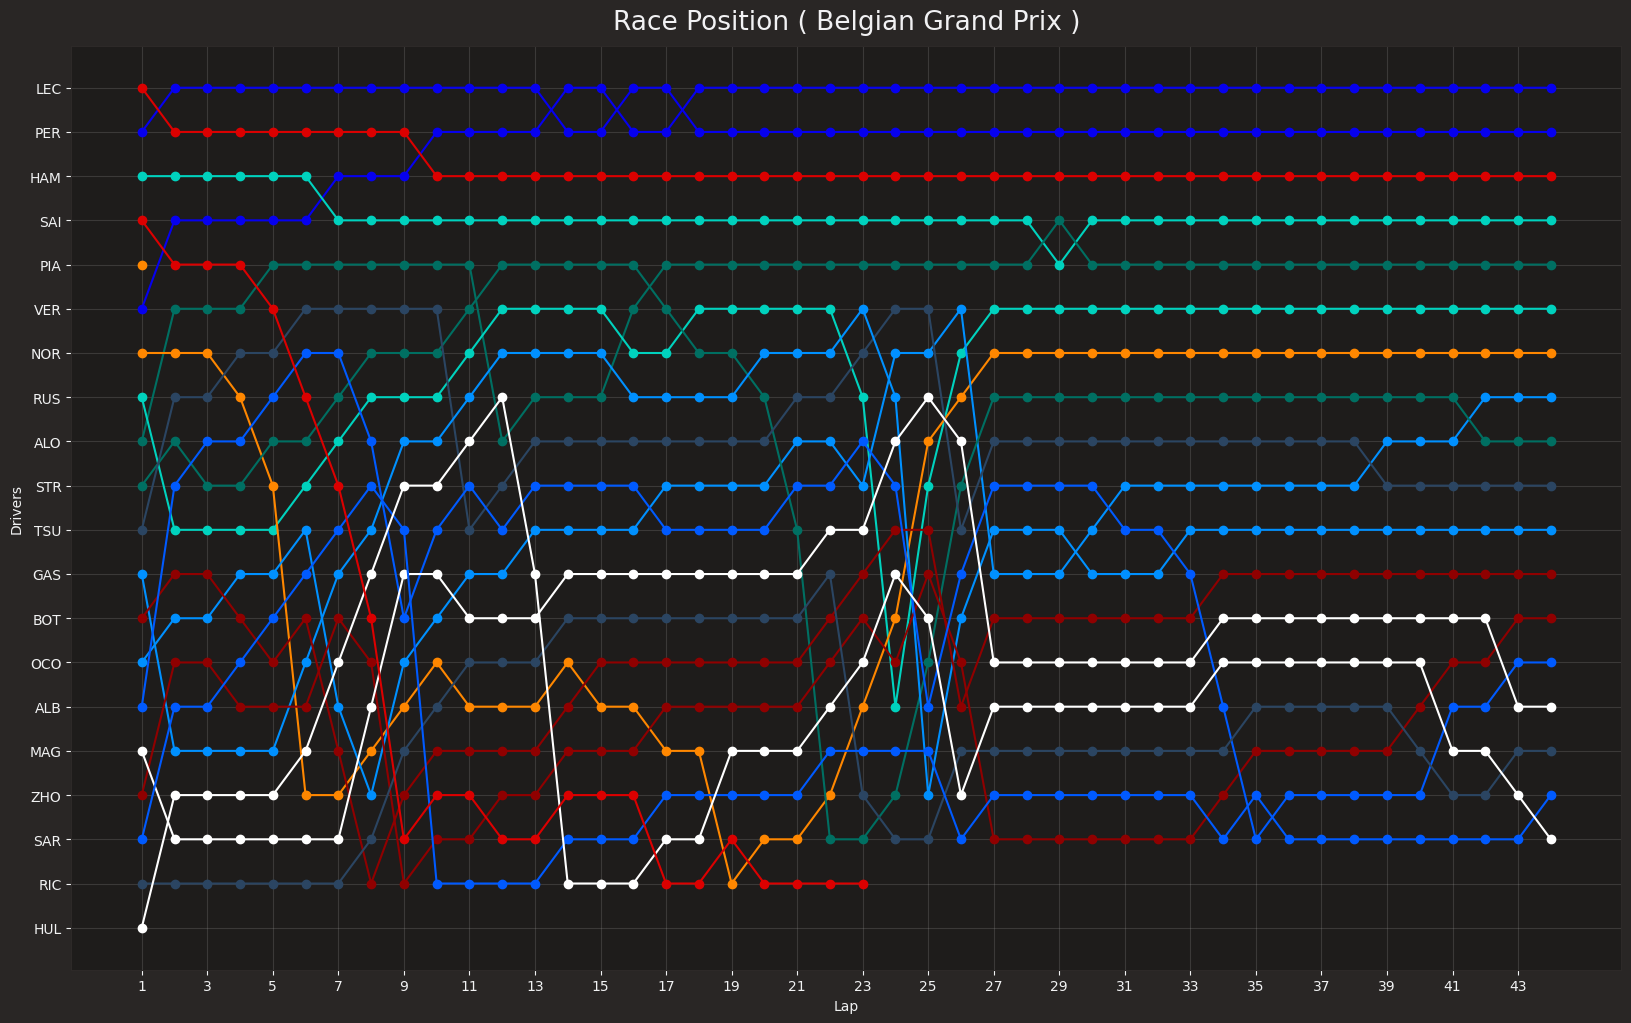

In [25]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(20, 12))

# Plot each line with dots using a loop
for i in drivers:
    ax.plot(position_drivers.loc[position_drivers["DriverNumber"]== i,["LapNumber"]], position_drivers.loc[position_drivers["DriverNumber"]== i,["Position"]] 
            , marker='o', linestyle='-', color = fastf1.plotting.team_color(session.get_driver(i)["TeamName"]) ,label=position_drivers.loc[(position_drivers["DriverNumber"]== i)&(position_drivers["LapNumber"]== 1),["Driver"]])

plt.title('Race Position ( '+session.event["EventName"]+' )')
plt.xlabel('Lap')
plt.ylabel('Drivers')
plt.xticks(range(1, max_lap(laps)+1, 2))
plt.yticks(range(1, len(drivers)+1),drivers_abr)
plt.gca().invert_yaxis()


# Add a legend
plt.grid(True, alpha=0.2)
# ax.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('Graphes/Race/RacePosition.png', dpi=300)
# Show the plot
plt.show()


### Race Pace 

In [26]:
# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [27]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

intr_qr

2.615000000000009

In [28]:
laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [29]:
results = session.results
drivers_to_visualize = results['Abbreviation'][:10]
drivers= results['Abbreviation']

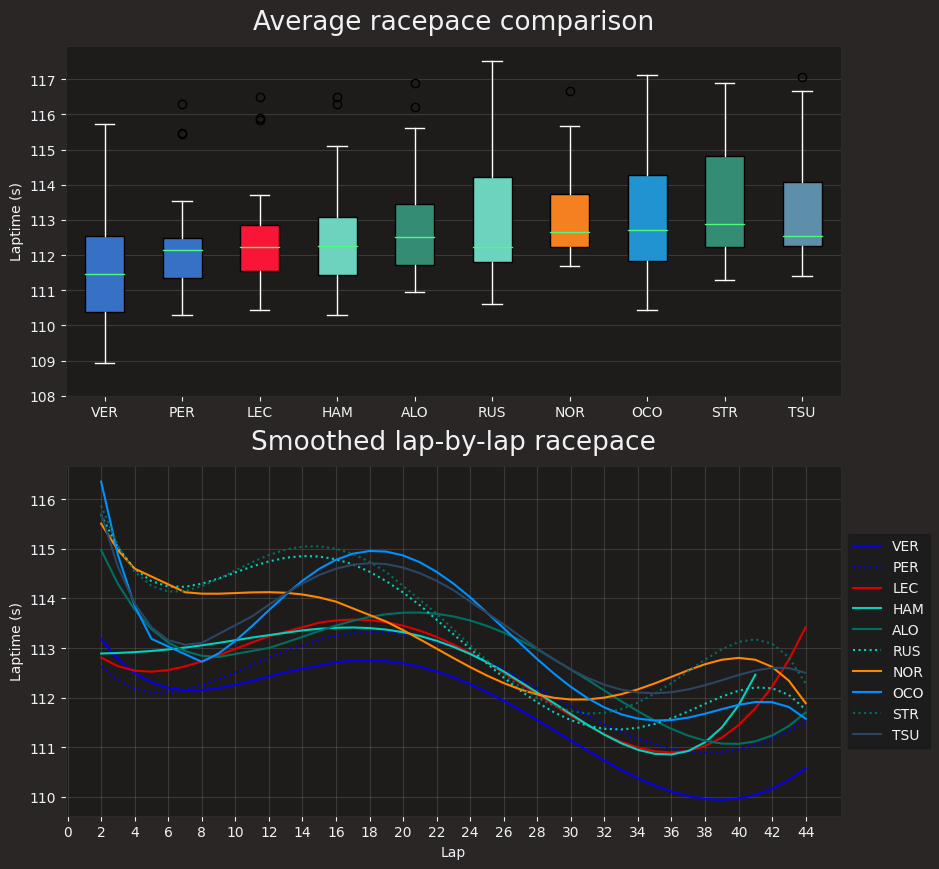

In [30]:
visualized_teams = []

fig, ax = plt.subplots(2, figsize=[10, 10])

##############################
#
# Boxplot for average racepace
#
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

# Create a list of colors for each boxplot

# Create the boxplot with custom colors
boxplot = ax[0].boxplot(laptimes, labels=drivers_to_visualize, patch_artist=True)

# Set the colors for each boxplot
for box, color in zip(boxplot['boxes'], '#'+session.results["TeamColor"]):
    box.set(facecolor=color)  # Set the face color of the box

# Set the line color to white
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='white')
    cap.set(color='white')
    
# Set the title and labels for the boxplot
ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)')



# ##############################
# #
# # Lap-by-lap racepace comparison
# #
# ##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=fastf1.plotting.team_color(team), linestyle=linestyle)
    
    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeSeconds']
    # scatter_marker = 'o' if team not in visualized_teams else '^' 
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)
    
    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # ax[1].set_xtrick(range(0,55),2)

    # Generate legend
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

plt.xticks(range(0,int(session.laps["LapNumber"].max()+2), 2))
ax[0].grid(axis='y',alpha=0.2)
ax[0].set_yticks(range(108,118,1))
ax[1].grid(True,alpha=0.2)
# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)
plt.savefig('Graphes/Race/racepace_comparison.png', dpi=300)

### Average Top Speed

In [31]:
drivers = session.drivers

In [32]:
drs_list = []
for i in drivers:
    lap = laps.pick_driver(i)
    drs = 0
    for j in range(0,len(lap)):
        if((lap.iloc[j].get_car_data()["DRS"]!=0).any()):
            drs = drs+1
    drs_list.append(drs)

In [33]:
from statistics import mean 
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []
df_top_speed = pd.DataFrame()
for i in drivers:
    if (laps.pick_driver(i).empty):
        print("The DataFrame is empty")
    else:
        Avg_Top_Speed = []
        for j in range(0,int(laps["LapNumber"].max())):
            if(laps.loc[(laps["LapNumber"]== j)&(laps["DriverNumber"]== i)].empty != True):
                max_speed = laps.loc[(laps["LapNumber"]== j)&(laps["DriverNumber"]== i)].get_car_data()["Speed"].max()
                Avg_Top_Speed.append(max_speed)
        Top_Speed = mean(Avg_Top_Speed)
        Driver = session.get_driver(i)[["DriverNumber"]].values[0]
        DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
        TeamColor = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
        driver_list.append(Driver)
        DriverAB_list.append(DriverAB)
        top_speed_list.append(Top_Speed)
        color_list.append(TeamColor)
df_top_speed["DriverNumber"] = driver_list
df_top_speed["Driver"] = DriverAB_list
df_top_speed["TopSpeed"] = top_speed_list
df_top_speed["Color"] = color_list
df_top_speed["DRS"] = drs_list
df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False)


c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` 

In [34]:
# remove all drivers that have a top speed that is low then usale which means that he had a DNF
for i in range(0,len(df_top_speed)):
    if(df_top_speed.iloc[i]["TopSpeed"] <= 300):
        df_top_speed = df_top_speed.drop(i)

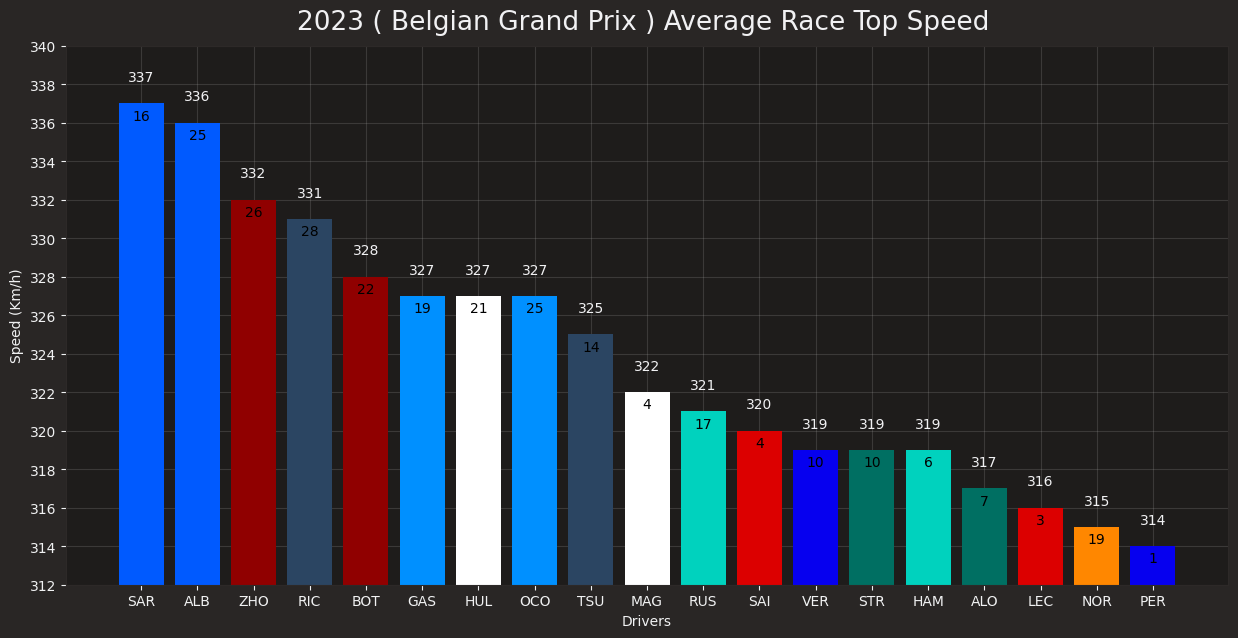

In [35]:
plt.figure(figsize=(15, 7))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)
d = df_top_speed["DRS"].reset_index(drop=True)
# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) Average Race Top Speed ')
plt.yticks(range(int(df_top_speed["TopSpeed"].min())-4, int(df_top_speed["TopSpeed"].max())+4, 2))
plt.ylim(int(df_top_speed["TopSpeed"].min()) -2,int(df_top_speed["TopSpeed"].max()) +3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+1, str(y.loc[i]), ha='center', va='bottom')

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]-1, str(d.loc[i]), ha='center', va='bottom',color='black')
    
plt.grid(True, alpha=0.2)
# Display the plot
plt.show()

### Average Speed

In [36]:
driver_list = []
DriverAB_list = []
avg_speed_list = []
color_list = []
df_avg_speed = pd.DataFrame()
for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).get_car_data()
        avg_Speed = round(max_speed["Speed"].mean())
        Driver = session.get_driver(i)[["DriverNumber"]].values[0]
        DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
        TeamColor = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
        driver_list.append(Driver)
        DriverAB_list.append(DriverAB)
        avg_speed_list.append(avg_Speed)
        color_list.append(TeamColor)
df_avg_speed["DriverNumber"] = driver_list
df_avg_speed["Driver"] = DriverAB_list
df_avg_speed["AvgSpeed"] = avg_speed_list
df_avg_speed["Color"] = color_list
df_avg_speed = df_avg_speed.sort_values(by='AvgSpeed', ascending=False).reset_index(drop=True)


c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` 

In [37]:
for i in range(0,len(df_avg_speed)):
    if(df_avg_speed.iloc[i]["AvgSpeed"] <= 200):
        df_avg_speed = df_avg_speed.drop(i)

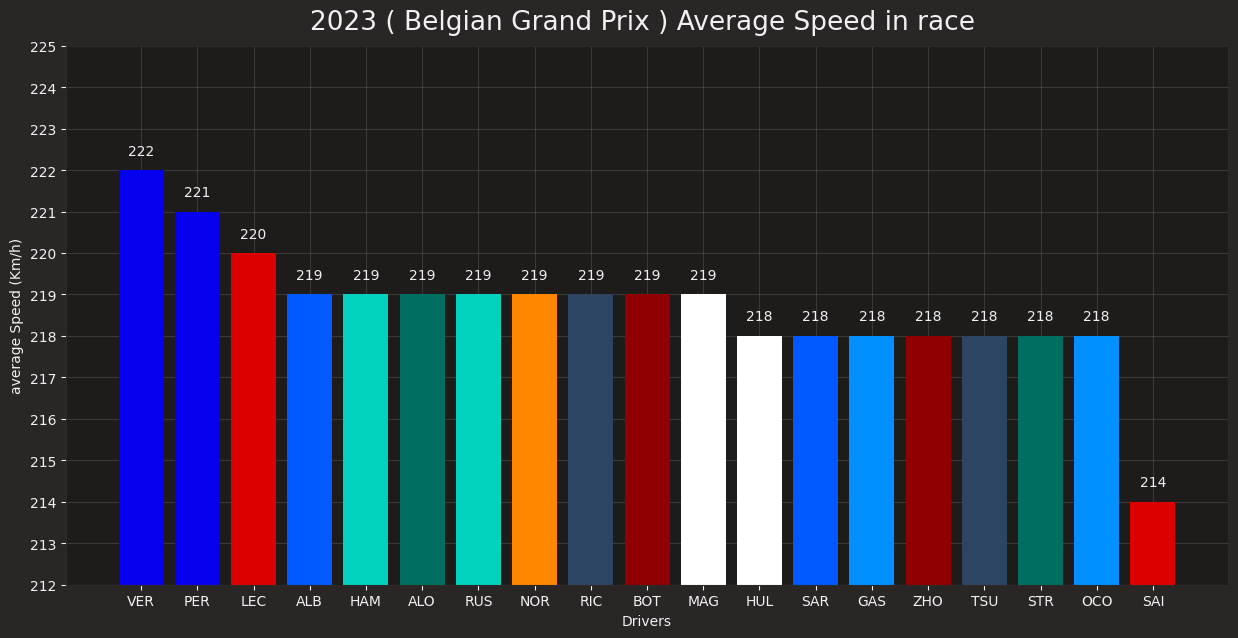

In [38]:
plt.figure(figsize=(15, 7))
x = df_avg_speed["Driver"].reset_index(drop=True)
y = df_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_avg_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) Average Speed in race ')
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(True, alpha=0.2)

# Display the plot
plt.show()

### Telemetry by lap

In [39]:
laps = session.laps
# max_lap = int(max_lap(laps)+1)
max_lap = 38
max_lap_time = int(session.laps["LapTime"].dt.total_seconds().max())
drivers = session.drivers

In [40]:
def DRS_Converter(DRS1):
    liste = []
    for i in range(len(DRS1)):
        if(DRS1.iloc[i]==8 or DRS1.iloc[i]==0):
            liste.append(0)
        else:
            liste.append(1)
    return(liste)

In [41]:
sector_time = []
lap = laps.pick_driver(1).pick_fastest()
sector_time.append(lap["Sector1Time"])
sector_time.append(lap["Sector2Time"])
sector_time.append(lap["Sector3Time"])
sector_time[1] = sector_time[0] + sector_time[1]
sector_time[2] = sector_time[1] + sector_time[2]
lap_tele = laps.pick_driver(1).pick_fastest().get_telemetry()
sector_distance = []
sector_distance.append(lap_tele.loc[lap_tele["Time"] <= sector_time[0],"Distance"].max())
sector_distance.append(lap_tele.loc[lap_tele["Time"] <= sector_time[1],"Distance"].max())
sector_distance.append(lap_tele["Distance"].max())

In [42]:
sector_distance[2]

6946.816055916177

In [43]:
drivers = ['1','44']

In [44]:
# Create void lists that contain data of each driver car
Distance = []
vcar = []
Throttle = []
Brake = []
DRS = []
RPM = []
nGear = []
Time = []
TimeS = []
max_speed = []

# insert data to lists that contain data of each driver car
for i in drivers:
    car_data = laps.loc[(laps["DriverNumber"]==i)&(laps["LapNumber"]==40)].get_telemetry()
    Distance.append(car_data['Distance'].values.tolist())
    vcar.append(car_data['Speed'].values.tolist())
    Throttle.append(car_data['Throttle'])
    Brake.append(car_data['Brake'])
    DRS.append(car_data['DRS'])
    RPM.append(car_data['RPM'])
    nGear.append(car_data['nGear'])
    # Time.append(car_data['Time'].values.tolist())
    Time.append(car_data['Time'].dt.total_seconds().values.tolist())
    max_speed.append(car_data.loc[car_data['Speed'].idxmax(),["Distance","Speed"]].values)

In [45]:
car_data['Speed'].idxmax()

719

In [46]:
list_1 = []
dif = len(Time[1])-len(Time[0])

if (dif<0):
    div = int(max([len(Time[1]),len(Time[0])])/abs(dif))
    for i in range(0,len(Time[0])):
        if ((i+1) % div != 0):
            list_1.append(Time[0][i])
    Time[0] = list_1
elif(dif>0):
    div = int(max([len(Time[1]),len(Time[0])])/abs(dif))
    for i in range(0,len(Time[1])):
        if ((i+1) % div != 0):
            list_1.append(Time[1][i])
    Time[1] = list_1
Time[1]= result = [a - b for a, b in zip(Time[0], Time[1])]
Time[0]= result = [a - b for a, b in zip(Time[0], Time[0])]

In [47]:
def min_length_list(list1, list2):
    if len(list1) <= len(list2):
        return list1
    else:
        return list2

In [48]:
max_speed[0][1]

316

In [61]:
corners_distance = [365,1045,1133,1251,2378,2497,2619,3063,3298,3792,4085,4483,4662,4913,5188,5894,6167,6702,6777]

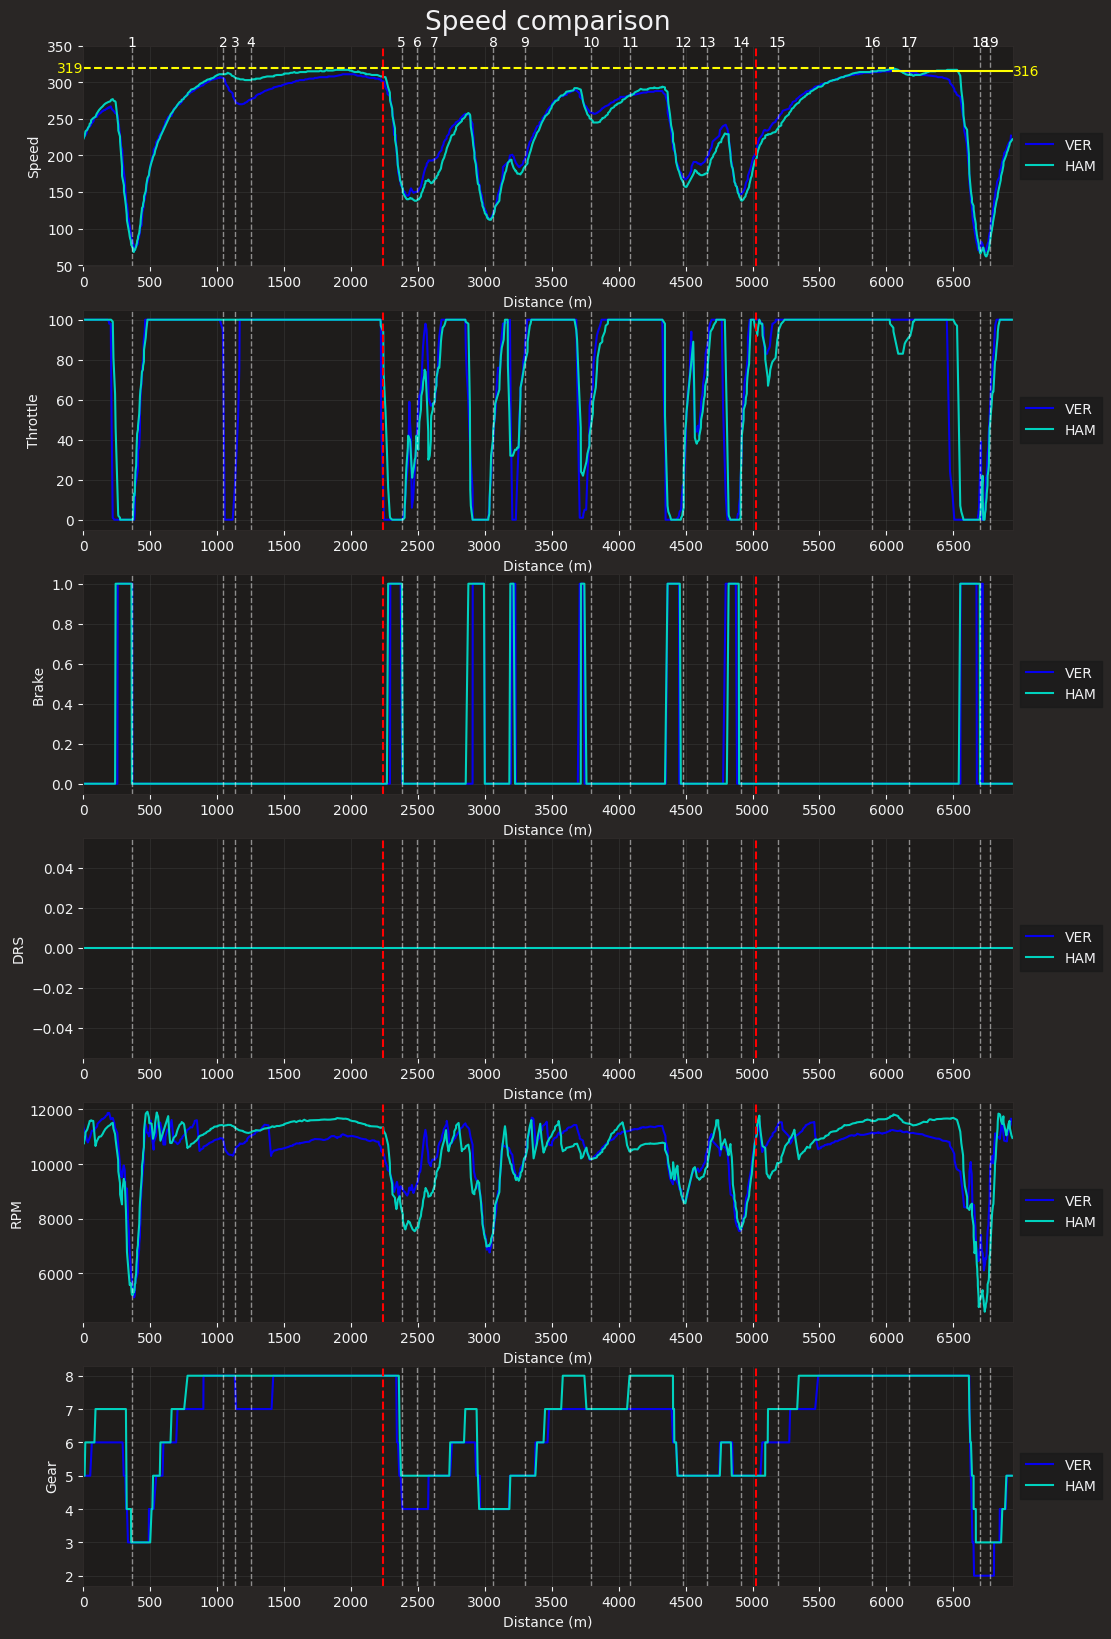

In [115]:
import matplotlib.pyplot as plt

# Data for the plots
color_picked = []
# Create subplots with 7 rows and 1 column
fig, axs = plt.subplots(6, 1, figsize=(12, 20))

# Plot the first graph in the first subplot
# print(len(Time[0]))
# print(len(Time[1]))
j=0
for i in drivers:
    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    if(team_color in color_picked):
        linestyle ='dashed'
    else:
        color_picked.append(team_color)
        linestyle ='solid'
        

    axs[0].plot(Distance[j], vcar[j], color=team_color,linestyle =linestyle ,label=driver_name)
    axs[1].plot(Distance[j], Throttle[j], color=team_color,linestyle =linestyle,label=driver_name)
    axs[2].plot(Distance[j], Brake[j], color=team_color,linestyle =linestyle,label=driver_name)
    axs[3].plot(Distance[j], DRS_Converter(DRS[j]),color=team_color,linestyle =linestyle,label=driver_name)
    axs[4].plot(Distance[j], RPM[j], color=team_color,linestyle =linestyle,label=driver_name)
    axs[5].plot(Distance[j], nGear[j], color=team_color,linestyle =linestyle,label=driver_name)
    # axs[6].plot(min_length_list(Distance[0], Distance[1]), Time[j], color=team_color,label=driver_name)
    j=j+1


axs[0].set_ylabel('Speed')
axs[1].set_ylabel('Throttle')
axs[2].set_ylabel('Brake')
axs[3].set_ylabel('DRS')
axs[4].set_ylabel('RPM')
axs[5].set_ylabel('Gear')
# axs[6].set_ylabel('Delta')

axs[0].set_title('Speed comparison')
# axs[1].set_title('Throttle comparison')
# axs[2].set_title('Brake comparison')
# axs[3].set_title('DRS comparison')
# axs[4].set_title('RPM comparison')
# axs[5].set_title('Gear comparison')
# Plot the first graph in the seventh subplot

# axs[3].get_figure().set_figheight(6)

# Plot the second graph in the seventh subplot
# axs[6].plot(Distance1, Delta, color='Red')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2)
for i in range(0,6):
    axs[i].set_xlabel('Distance (m)')
    axs[i].grid(True,alpha = 0.1)
    axs[i].set_xticks(range(0, 8000, 500)) 
    axs[i].set_xlim(0, sector_distance[2]) 
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[i].axvline(x=sector_distance[0], color='red', linestyle='--')
    axs[i].axvline(x=sector_distance[1], color='red', linestyle='--')
    for j in range(0,len(corners_distance)):
        axs[i].axvline(x=corners_distance[j], color='white', linestyle='--', linewidth=1, alpha=0.5)
for j in range(0,len(corners_distance)):
    axs[0].text(corners_distance[j],355,str(j+1), ha='center', va='center',color='white')
    
axs[0].set_yticks(range(50, 360, 50)) 

axs[0].axhline(y=max_speed[0][1], color='yellow', linestyle='solid', xmin=(max_speed[0][0]/sector_distance[2]))
axs[0].axhline(y=max_speed[1][1], color='yellow', linestyle='dashed', xmax=(max_speed[1][0]/sector_distance[2]))
axs[0].text(sector_distance[2], max_speed[0][1], str(max_speed[0][1]), ha='left', va='center',color='yellow')
axs[0].text(0, max_speed[1][1], str(max_speed[1][1]), ha='right', va='center',color='yellow')

plt.plot()
# Show the plot
plt.show()

### Overtaking difference 

In [50]:
max =laps.pick_driver(1).loc[laps["LapNumber"]== 6].get_telemetry()
ham =laps.pick_driver(44).loc[laps["LapNumber"]== 6].get_telemetry()

In [51]:
max = max.loc[(max["Distance"]>= 2000)&(max["Distance"]<= 2500)]
ham = ham.loc[(max["Distance"]>= 2000)&(ham["Distance"]<= 2500)]

In [52]:
top = max.loc[max["Speed"].idxmax()]
dis = top["Distance"]
dis

2174.928611111111

In [53]:
def find_closest_number(numbers_list, target):
    closest_number = None
    min_difference = float('inf')

    for num in numbers_list:
        difference = abs(num - target)
        if difference < min_difference:
            min_difference = difference
            closest_number = num

    return closest_number